In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# cd /content/drive/Othercomputers/My Laptop/Documents/TUM/Courses/mps_mnist

In [3]:

import sys
import time
from contextlib import contextmanager

import matplotlib.pyplot as plt
import scipy.sparse.linalg
from numba import jit
from tqdm import notebook
import pandas as pd

from data_loader import *
import os

from cycler import cycler
fontsize = 12
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD'])

plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['legend.title_fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['text.usetex'] =  'false'
# plt.rcParams['axes.grid'] = 'True'
plt.rcParams['figure.figsize'] =  3,3.5



# plt.style.use('report_stylesheet_standard.mplstyle')


@contextmanager
def suppress_stdout():

    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


def timeit(func):
    def inner(*args, **kwargs):
        t0 = time.time()
        result = func(*args, **kwargs)
        print('duration of "{}": {}'.format(func.__name__, time.time() - t0))
        return result

    return inner


def save_data_to_pickle(func, arguments, file_path, run_always=False):
    if os.path.exists(file_path) and not run_always:

        with open(file_path, 'rb') as f:
            print('Data already exists, loading data...')
            result = pickle.load(f)

    else:
        if not os.path.exists(os.path.dirname(file_path)):
            print(os.path.dirname(file_path))
            os.makedirs(os.path.dirname(file_path))
        result = func(*arguments)
        with open(file_path, 'wb') as f:
            pickle.dump(result, f)

    return result


# @timeit
# def overlap(bra, ket=None):
#
#     """
#     More efficient:
#     1) ket to left
#     2) (ket and left) to bra
#     :param bra:
#     :param ket:
#     :return:
#     """
#
#     if ket is None:
#         ket = bra
#
#     braket = np.ones((1, 1))
#     for bra_i, ket_i in zip(bra, ket):
#         ket_i = np.tensordot(braket, ket_i, (1, 0))
#         braket = np.tensordot(bra_i.conj(), ket_i, ((0, 1), (0, 1)))
#     return braket.item()


In [9]:
class DataProcessing:
    def __init__(self, dataset, mapping_basis, even_distribution=False, max_nb_images=None):
        assert mapping_basis in ['orthogonal', 'original', 'sin_cos', 'sines', 'sines2'], 'mapping_basis should be one of ["orthogonal", "original", "sin_cos"]'
        self.mapping_basis = mapping_basis
        self.max_nb_images = max_nb_images
        self.original_images, self.labels = dataset

        self.images = self.transform(self.original_images)

        if even_distribution:
            self.sorted_images = self.get_digits(self.images, self.labels)
            self.sorted_images = self.create_even_distribution(self.sorted_images)

    @staticmethod
    def flat_to_2d(batch):
        H = W = int(np.sqrt(batch.shape[-1]))
        return batch.reshape((-1, H, W))

    @staticmethod
    def square_to_flat(batch):
        H = batch.shape[-1]
        return batch.reshape((-1, H ** 2))

    def mean_pooling(self, images_, filter_size):
        images_2d = self.flat_to_2d(images_)
        H, W = images_2d.shape[-2:]
        H_new = H // filter_size
        W_new = W // filter_size
        new_shape = images_2d.shape[:1] + (H_new, filter_size, W_new, filter_size)
        result = np.mean(images_2d.reshape(new_shape), axis=(2, 4))
        result = self.square_to_flat(result)
        return result

    @staticmethod
    def scale(images_, domain=(0, 255), range_=(0, 1)):
        scaled = images_ / (domain[1] - domain[0]) * (range_[1] - range_[0]) + range_[0]
        return scaled

    def mapping(self, mat):
        print(mat.shape)
        if self.mapping_basis == 'orthogonal':
            qstate = np.array([np.exp(mat * 3.j * np.pi / 2) * np.cos(mat * np.pi / 2), np.exp(-mat * 3.j * np.pi / 2) * np.sin(mat * np.pi / 2)])
        elif self.mapping_basis == 'original':
            qstate = np.array([np.cos(mat * np.pi / 2), np.sin(mat * np.pi / 2)])
        elif self.mapping_basis == 'sin_cos':
            qstate = np.array([np.sin(np.pi*1/2 * mat),
                               np.cos(np.pi*1/2 * mat),
                               np.sin(np.pi*3/2 * mat),
                               np.cos(np.pi*3/2 * mat)])

        elif self.mapping_basis == 'sines':
            qstate = np.array([np.sin(np.pi*1/2 * mat),
                               np.sin(np.pi*3/2 * mat),
                               np.sin(np.pi*5/2 * mat),
                               np.sin(np.pi*7/2 * mat)])
            qstate /= np.linalg.norm(qstate, axis=0)

        elif self.mapping_basis == 'sines2':
            qstate = np.array([np.sin(np.pi*1 * mat),
                               np.sin(np.pi*2 * mat),
                               np.sin(np.pi*3 * mat),
                               np.sin(np.pi*4 * mat)])

            # print(np.linalg.norm(qstate, axis=0).shape)
            qstate /= (np.linalg.norm(qstate, axis=0))
        else:
            print('Mapping basis not valid')
            return
        return qstate.transpose(1, 2, 0)

    @staticmethod
    def get_digits(mat, labels_):
        sorted_digits_ = []
        for label in np.unique(labels_):
            label_slice = (labels_ == label)
            sorted_digits_.append(mat[label_slice])

        return sorted_digits_

    def transform(self, images_):
        course_grain = self.mean_pooling(images_, 2)

        if self.mapping_basis == 'sines':
            scaled = self.scale(course_grain, domain=(0, 1), range_=(0.1,1))
        elif self.mapping_basis == 'sines2':
            scaled = self.scale(course_grain, domain=(0, 1), range_=(0.1,0.9))

        else:
            scaled = self.scale(course_grain, domain=(0, 1))
        mapped = self.mapping(scaled)
        return mapped

    def create_even_distribution(self, batch):
        if self.max_nb_images is None:
            smallest_batch_size = np.min([len(dbatch) for dbatch in batch])
            even_batch = np.array([dbatch[:smallest_batch_size] for dbatch in batch]).copy()
            return even_batch
        else:
            even_batch = np.array([dbatch[:self.max_nb_images] for dbatch in batch]).copy()
            return even_batch


    def show_pic(self):
        pixels = self.sorted_images.shape[-2]
        h = int(pixels**(1/2))

        for i in range(4):
            plt.figure()
            image  = self.sorted_images[0,0,:,i].reshape((h,h))
            plt.imshow(image)


In [16]:
class Normalization:
    def __init__(self, batch, mapping_basis):
        nb_images = batch[0].shape[0]
        norms_save_path = os.path.join('results',mapping_basis,'norms','norm_{}.p'.format(nb_images))
        self.norms = save_data_to_pickle(self.get_norms_all_digits, (batch,), norms_save_path, run_always=False)
        self.wfs = self.normalize_all_digits(batch, self.norms)

    @staticmethod
    def normalize_all_digits(batch, norms):
        for i in range(len(batch)):

            batch[i] /= (norms[i] ** (1 / (2 * batch[i].shape[1])))
        return batch

    def get_norms_all_digits(self, batch):
        norms = []
        for digit_batch in notebook.tqdm_notebook(batch):
            norm = self.get_norm_single_digit(digit_batch)
            norms.append(norm)
        return np.array(norms)

    @staticmethod
    @timeit
    def get_norm_single_digit(digit_batch):
        @jit(nopython=True)
        def contract_physical(node_idx):
            return np.ascontiguousarray(digit_batch[:, node_idx, :]) @ np.ascontiguousarray(
                digit_batch[:, node_idx, :].T.conj())


        product = contract_physical(0)
        for i in range(1, 196):
            product *= contract_physical(i)
        norm = np.sum(product)
        norm = np.abs(norm)
        # print(norm)
        return norm

    @staticmethod
    def get_overlaps_single_image(image_mps, dfunc):
        physical_contract = np.sum([image_mps[:,i].conj() * dfunc[:,:,:,i] for i in range(image_mps.shape[-1])], axis=0)
        virtual_contract = np.prod(physical_contract, 2)
        overlap = np.sum(virtual_contract, 1)
        overlap = np.abs(overlap)
        return overlap

    @timeit
    def get_accuracy_exact(self, test_images, test_labels, N=None):
        if N is None:
            N = len(test_images)
        preds = []
        for image in notebook.tqdm_notebook(test_images[:N]):
            pred = np.argmax(self.get_overlaps_single_image(image, self.wfs))
            preds.append(pred)

        preds = np.array(preds)
        # print(preds.shape)
        accuracy = np.sum(test_labels[:N] == preds) / N

        return accuracy


In [36]:
class CompressedWFS:
    def __init__(self, max_bond_dim, ewfs, mapping_basis):
        self.mapping_basis = mapping_basis
        self.ewfs = ewfs


        self.nb_basis_elements = self.ewfs[0].shape[-1]

        self.max_bond_dim = max_bond_dim
        self.cwfs = self.create_random_compressed_wfs(196, max_bond_dim, self.nb_basis_elements)

        self.cwfs_reshaped = self.reshape_cwfs()

    def reshape_cwfs(self):
        cwfs_reshaped = []
        for m_i in range(len(self.cwfs[0])):
            single_m = []
            for mps in self.cwfs:
                single_m.append(mps[m_i])

            single_m = np.array(single_m)
            cwfs_reshaped.append(single_m)
            # print(cwfs_reshaped[0].shape)
        return cwfs_reshaped

    def sweep(self, run_always=False, sweep_number=1):
        def sweep_inner(self):
            cwfs = []
            print('Sweeping through MPS')
            for cmps, emps in notebook.tqdm_notebook(zip(self.cwfs, self.ewfs)):
                self.perform_svd_full_mps(cmps)
                self.sweep_mps(cmps, emps)
                cwfs.append(cmps)
            return cwfs
        cwfs_file_name = 'cwfs_chi{}_s{}.p'.format(self.max_bond_dim, sweep_number)
        # print('aaaa')
        cwfs_path = os.path.join('results', self.mapping_basis ,'cwfs', cwfs_file_name)
        self.cwfs = save_data_to_pickle(sweep_inner, (self,),
                                        cwfs_path,
                                        run_always=run_always)
        self.cwfs_reshaped = self.reshape_cwfs()

    @staticmethod
    def sweep_mps(cmps, emps):
        """

        :param cmps: list: 196 entries with shape [chi_left, physical, chi_right]
        :param emps: np.array: [4506, 196, 2]
        :return:
        """
        nb_basis_elements = emps.shape[-1]

        def contract_single_bond(i):
            physical_contract_ = np.tensordot(emps[:, i, :], cmps[i].conj(), (1, 1))
            return physical_contract_


        right_contr_list = [np.ones((1,1,len(emps)))]


        for m_idx in reversed(range(len(cmps) - 1)):
            virtual = np.array([right_contr_list[-1] * emps[:,m_idx+1, basis_element] for basis_element in range(nb_basis_elements)])
            # virtual = np.array([right_contr_list[-1] * emps[:,m_idx+1,0], right_contr_list[-1] * emps[:,m_idx+1,1]])
            physical = np.tensordot(cmps[m_idx+1].conj(), virtual, ((1,2),(0,1)))
            # physical_contract = contract_single_bond(m_idx + 1)
            # right_contract = np.ascontiguousarray(physical_contract) @ np.ascontiguousarray(right_contr_list[-1])
            right_contr_list.append(physical)
        right_contr_list.reverse()



        left_contr_list = [np.ones((1,1,len(emps)))]
        for m_idx in range(len(cmps) - 1):
            right_contract = right_contr_list[m_idx]
            updated_m_left = np.array([left_contr_list[-1] * emps[:, m_idx, basis_element] for basis_element in range(nb_basis_elements)])
            # updated_m_left = np.array([left_contr_list[-1] * emps[:, m_idx, 0], left_contr_list[-1] * emps[:, m_idx, 1]])
            updated_m = np.tensordot(updated_m_left, right_contract, (-1, -1))

            updated_m_sliced = updated_m[:, :, 0, :, 0].transpose((1, 0, 2))
            legs_together = updated_m_sliced.reshape((-1, updated_m_sliced.shape[-1]))
            A, S, V = scipy.linalg.svd(legs_together, full_matrices=False, lapack_driver='gesdd')

            updated_m_left_canonical = A.reshape(updated_m_sliced.shape[0], nb_basis_elements, -1)
            cmps[m_idx] = updated_m_left_canonical

            virtual = np.array([left_contr_list[-1] * emps[:,m_idx, basis_element] for basis_element in range(nb_basis_elements)])
            # virtual = np.array([left_contr_list[-1] * emps[:,m_idx,0], left_contr_list[-1] * emps[:,m_idx,1]])
            physical = np.tensordot(cmps[m_idx].conj(), virtual, ((1,0),(0,1)))

            # physical_contract = contract_single_bond(m_idx)
            # contract_left = np.ascontiguousarray(left_contr_list[-1]) @ np.ascontiguousarray(physical_contract)
            left_contr_list.append(physical)


        right_contr_list = [np.ones((1,1,len(emps)))]
        for m_idx in reversed(range(len(cmps))):
            left_contract = left_contr_list[m_idx]
            updated_m_right = np.array([right_contr_list[-1] * emps[:, m_idx, basis_element] for basis_element in range(nb_basis_elements)])
            # updated_m_right = np.stack([right_contr_list[-1] * emps[:, m_idx, 0], right_contr_list[-1] * emps[:, m_idx, 1]])

            updated_m = np.tensordot(left_contract, updated_m_right, (-1, -1))


            updated_m_sliced = updated_m[:, 0, :, :, 0]
            legs_together = updated_m_sliced.reshape((updated_m_sliced.shape[0], -1))
            A, S, V = scipy.linalg.svd(legs_together, full_matrices=False, lapack_driver='gesdd')
            updated_m_right_canonical = V.reshape(-1, nb_basis_elements, updated_m_sliced.shape[-1])
            cmps[m_idx] = updated_m_right_canonical

            virtual = np.array([right_contr_list[-1] * emps[:,m_idx, basis_element] for basis_element in range(nb_basis_elements)])
            # virtual = np.array([right_contr_list[-1] * emps[:,m_idx,0], right_contr_list[-1] * emps[:,m_idx,1]])
            physical = np.tensordot(cmps[m_idx].conj(), virtual, ((1,2),(0,1)))
            right_contr_list.append(physical)

    @staticmethod
    def create_random_compressed_wfs(mps_length, max_bond_dim, nb_basis_elements):
        def create_mps():
            mps = [np.random.random((1, nb_basis_elements, max_bond_dim))]
            if mps_length - 2:
                tile = np.zeros((max_bond_dim, nb_basis_elements, max_bond_dim))
                for i in range(nb_basis_elements):
                    tile[:, i, :] = np.diag(np.random.random(max_bond_dim))
                    # tile[:, 1, :] = np.diag(np.random.random(max_bond_dim))
                mps += [tile] * (mps_length - 2)
            mps.append(np.random.random((max_bond_dim, nb_basis_elements, 1)))
            return mps

        compressed_wfs = []
        for i in range(10):
            compressed_wfs.append(create_mps())

        return compressed_wfs

    @staticmethod
    def perform_svd_full_mps(mps):

        """
        @param mps: ndarray/list of MPS: (nb_matrices, left virtual, physical, right virtual)
        @return: mps in canonical form
        """
        for m_i in reversed(range(len(mps))):
            matrix = np.array(mps[m_i])
            if m_i == 0:
                mps[m_i] /= np.sqrt(np.tensordot(matrix, matrix.conj(), axes=([0, 1, 2], [0, 1, 2])))
                continue
            else:
                pass

            legs_together = matrix.reshape((matrix.shape[0], -1))
            A, S, V = scipy.linalg.svd(legs_together, full_matrices=False, lapack_driver='gesdd')
            V_legs_apart = V.reshape(-1, *matrix.shape[1:])

            mps[m_i] = V_legs_apart

            mps[m_i - 1] = mps[m_i - 1] @ A * S

    def get_prediction(self, image):
        braket = np.ones((10, 1, 1))
        for ket_i, bra_i in zip(self.cwfs_reshaped, image):
            physical_contract = np.sum([ket_i[:,:,i,:] * bra_i[i].conj() for i in range(self.nb_basis_elements)], axis=0)
            # physical_contract = ket_i[:, :, 0, :] * bra_i[0].conj() + ket_i[:, :, 1, :] * bra_i[1].conj()
            braket = braket @ physical_contract

        prediction = np.argmax(np.absolute(braket[:, 0, 0]))
        return prediction

    def get_accuracy(self, test_images, test_labels, N=None):
        if N is None:
            N = len(test_images)

        preds = []
        for image in notebook.tqdm_notebook(test_images):
            preds.append(self.get_prediction(image))
        preds = np.array(preds)
        accuracy = np.sum(test_labels[:N] == preds) / N
        return accuracy

    def get_truncation_overlap(self):
        """
        cwfs: (list(N),list(D),L,P,R)
        ewfs: (D,N,HxW, P)
        @return:
        """
        overlaps = []
        for cmps, emps in notebook.tqdm_notebook(zip(self.cwfs, self.ewfs)):
            contract = np.ones((1, 1))
            for i in range(len(cmps)):
                print(cmps[i].shape)
                """
                emps: (N,HxW,P)
                cmps[i]: (L,P,R)
                """
                physical = np.tensordot(emps[:, i, :], cmps[i].conj(), (1,1))
                """"
                (N,L,R)
                """
                contract = np.ascontiguousarray(contract) @ np.ascontiguousarray(physical)


            overlaps.append(np.linalg.norm(np.sum(contract)))

        return overlaps


In [40]:
class Analysis:
    def __init__(self, ewfs_o, chimaxs, nb_sweeps, mapping_basis, val):
        self.val = val
        self.ewfs_o = ewfs_o
        self.chimaxs = chimaxs
        self.nb_sweeps = nb_sweeps
        self.mapping_basis = mapping_basis

        self.data_root = os.path.join('results',mapping_basis)

        self.compression_path = os.path.join(self.data_root, 'results.csv')
        self.df = self.load_df(self.compression_path, ['chi_max', 'nb_sweeps', 'compression_duration', 'accuracy', 'truncation_overlap', 'nb_test_images'])
        self.df = self.df.reset_index(drop=True)



        print('Basis: ', mapping_basis)
        self.get_performance_vs_chimax()
        self.get_performance_vs_nb_images()


    def get_performance_vs_nb_images(self, nb_of_images=(4506)):
        nb_images_df_path = os.path.join(self.data_root, 'acc_vs_nb_path.csv')
        nb_images_df = self.load_df(nb_images_df_path, ['nb_images_exact', 'accuracy','truncation_overlap'])
        nb_images_df = nb_images_df.reset_index(drop=True)

        for nb_images in [4506,]:
            print('Running: # of images: ', nb_images)
            if nb_images in nb_images_df['nb_images_exact'].astype(int).values:
                print('Already performed calc. skipping...')
                continue

            train_small = DataProcessing(train_data, even_distribution=True, max_nb_images=nb_images, mapping_basis=self.mapping_basis)
            ewfs_o_small = Normalization(train_small.sorted_images, self.mapping_basis)
            overlaps = self.get_overlap_empss_new(self.ewfs_o.wfs, ewfs_o_small.wfs)
            accuracy = ewfs_o_small.get_accuracy_exact(self.val.images, self.val.labels)
            # accuracy = 0.9209

            nb_images_df.loc[len(nb_images_df)]  = [nb_images, accuracy, overlaps.tolist()]
            nb_images_df.to_csv(nb_images_df_path, sep=',')


    def get_overlap_empss_new(self, emps_full, emps_small):
        overlaps = []
        for digit in notebook.tqdm_notebook(range(len(emps_small))):
            overlap = self.get_overlap_single_digit(digit, emps_full,emps_small)
            overlaps.append(overlap)
        return np.array(overlaps)

    @staticmethod
    def get_overlap_single_digit(digit, emps_full, emps_small):
        @jit(nopython=True)
        def contract_physical(node_idx):
            return np.ascontiguousarray(emps_full[digit,:, node_idx, :]) @ np.ascontiguousarray(
                emps_small[digit,:, node_idx, :].T.conj())


        product = contract_physical(0)
        for i in range(1, 196):
            product *= contract_physical(i)
        overlap = np.sum(product)
        overlap = np.abs(overlap)
        return overlap

    @staticmethod
    def get_overlap_empss(emps_full, emps_small):

        nb_basis_elements = emps_full.shape[-1]
        overlaps = []
        for digit in notebook.tqdm_notebook(range(len(emps_small))):
            overlap = np.ones((emps_small.shape[1], emps_full.shape[1]))
            for m_i in range(emps_small.shape[2]):
                m_full = emps_full[digit,:,m_i,:]
                m_small = emps_small[digit,:,m_i,:]


                # virtual_contract_full = np.array([overlap * m_full[:,0], overlap * m_full[:,1]])
                virtual_contract_full = np.array([overlap * m_full[:,i] for i in range(nb_basis_elements)])
                # virtual_contract_small = np.array([virtual_contract_full * m_small[:,0][..., np.newaxis].conj(), virtual_contract_full * m_small[:,1][..., np.newaxis].conj()])
                virtual_contract_small = np.array([virtual_contract_full * m_small[:,i][..., np.newaxis].conj() for i in range(nb_basis_elements)])


                overlap = np.sum([virtual_contract_small[i,i,:] for i in range(nb_basis_elements)], axis=0)

                # overlap = virtual_contract_small[0,0,:] + virtual_contract_small[1,1,:]

            overlap = np.linalg.norm(np.sum(overlap))
            overlaps.append(overlap)
        return overlaps

    @staticmethod
    def load_df(path, columns):
        if not os.path.exists(path):
            df = pd.DataFrame(columns=columns)
        else:
            df = pd.read_csv(path, delimiter=',', index_col=0)
        return df


    def get_performance_vs_chimax(self):


        for chimax in self.chimaxs:
            print('Running chimax: ', chimax)
            all_sweeps_exists = self.check_if_all_sweeps_already_performed(chimax, self.nb_sweeps)
            # if all_sweeps_exists:
            #     print('Chimax already fully calculated')
            #     continue

            cwfs = CompressedWFS(chimax, ewfs=ewfs_o.wfs, mapping_basis=self.mapping_basis)
            for sweep in range(1,self.nb_sweeps+1):
                print(len(cwfs.cwfs))
                print(len(cwfs.cwfs[5]))
                print(len(cwfs.cwfs[5][5]))
                print(cwfs.cwfs[5][5].shape)
                print('Sweep: ', sweep)
                t0 = time.time()
                cwfs.sweep(sweep_number=sweep)
                sweep_duration = time.time() - t0
                print('Compression done.')
                exists = self.check_if_already_performed(chimax, sweep)
                if not exists:
                    found_index, cwfs_path = exists
                    # continue
                else:
                    print('Getting accuracy..')
                    # accuracy = cwfs.get_accuracy(val.images, val.labels)
                    print('Getting truncation overlap..')
                    truncation_overlap = cwfs.get_truncation_overlap()
                    results = [chimax, sweep, sweep_duration, accuracy, truncation_overlap, len(val.labels)]
                    self.df.loc[len(self.df.index)] = results
                    self.df.to_csv(self.compression_path, sep=',')

    def check_if_all_sweeps_already_performed(self, chimax, max_sweep):

        for sweep in range(1, max_sweep+1):
            df_found = self.df[(self.df['chi_max'] == chimax) & (self.df['nb_sweeps'] == sweep)]
            if not len(df_found):
                return False

            cwfs_file_name = 'cwfs_chi{}_s{}.p'.format(chimax, sweep)
            cwfs_path = os.path.join(self.data_root, 'cwfs', cwfs_file_name)
            if not os.path.exists(cwfs_path):
                return False

        return True

    def check_if_already_performed(self, chimax, sweep):
        results_exists = False
        cwfs_exists = False

        df_found = self.df[(self.df['chi_max'] == chimax) & (self.df['nb_sweeps'] == sweep)]
        if len(df_found) > 0:
            results_exists = True

        cwfs_file_name = 'cwfs_chi{}_s{}.p'.format(chimax, sweep)
        cwfs_path = os.path.join(self.data_root, 'cwfs', cwfs_file_name)
        if os.path.exists(cwfs_path):
            cwfs_exists = True

        if cwfs_exists & results_exists:
            return df_found.index, cwfs_path



In [39]:
from scipy.stats.mstats import gmean
from ast import literal_eval
class Plotting:
    def __init__(self, mapping_basis=('orthogonal', 'original', 'sines')):

        self.mapping_basis = mapping_basis
        self.acc_overlap_vs_chimax()
        # self.acc_overlap_vs_nb_images()

    def acc_overlap_vs_chimax(self):
        fig, ax = plt.subplots()
        ax_overlap = ax.twinx()

        for basis in self.mapping_basis:
            df_path = os.path.join('results', basis, 'results.csv')
            try:
                df = pd.read_csv(df_path, sep=',')
            except FileNotFoundError:
                continue

            if basis == 'original':
                label='non-ortho'
            else:
                label='ortho'

            df = df.sort_values(['chi_max'], ignore_index=True)
            max_sweeps_df = df[df['nb_sweeps'] == 3]
            new_df = max_sweeps_df['truncation_overlap'].apply(literal_eval)
            overlap_gmean = new_df.apply(gmean)
            ax.plot(max_sweeps_df['chi_max'], max_sweeps_df['accuracy'], '-o', label=label)
            ax_overlap.plot(max_sweeps_df['chi_max'], overlap_gmean**2, '--o', label=label)
        ax_overlap.set_ylabel(r'Mean of overlaps $| \langle \Sigma_l^\chi | \Sigma_l \rangle |^2$', fontsize=12)
        ax.set_xlabel('$\chi$', fontsize=12)
        ax.set_ylabel('$Accuracy$', fontsize=12)
        ax.grid(True)
        ax.text(2,0.93,'(b)')

        ax.set_axisbelow(True)
        ax.legend(fontsize=12,  loc='lower right')
        fig.savefig('figures/accuracy_and_overlap_vs_chimax.pdf',bbox_inches='tight')

    def acc_overlap_vs_nb_images(self):
        fig, ax = plt.subplots(figsize=(3.5,3.5))
        ax_overlap = ax.twinx()

        for basis in self.mapping_basis:
            df_path = os.path.join('results', basis, 'acc_vs_nb_path.csv')
            df = pd.read_csv(df_path, sep=',')
            df = df.sort_values('nb_images_exact')
            print(df['truncation_overlap'])
            new_df = df['truncation_overlap'].apply(literal_eval)
            overlap_gmean = new_df.apply(gmean)
            ax.plot(df['nb_images_exact'], df['accuracy'], '-o', label=basis)
            ax.set_xlabel('# of images', fontsize=12)
            ax.set_ylabel('$accuracy$', fontsize=12)
            # ax.grid(True)
            ax_overlap.plot(df['nb_images_exact'], overlap_gmean, 'o:', label=basis)
            ax_overlap.set_ylabel('truncation overlap', fontsize=12)
            ax.legend(fontsize=12)
            # fig.savefig('figures/accuracy_and_overlap_vs_nb_images.pdf',bbox_inches='tight')


In [41]:
mnist_data_path = os.path.join('data','mnist.pkl.gz')

data = load_data(mnist_data_path)
train_data, val_data, test_data = data


bases = ['orthogonal', 'original', 'sines', 'sines2']

for basis in bases[:2]:
    train = DataProcessing(train_data, even_distribution=True, mapping_basis=basis)
    val = DataProcessing(val_data, mapping_basis=basis)
    test = DataProcessing(test_data, mapping_basis=basis)
    # train.show_pic()
    ewfs_o = Normalization(train.sorted_images, mapping_basis=basis)



    Analysis(ewfs_o, [10], 3, basis, val)


(50000, 196)
(10000, 196)
(10000, 196)
Data already exists, loading data...
Basis:  orthogonal
Running chimax:  10
10
196
10
(10, 2, 10)
Sweep:  1
Data already exists, loading data...
Compression done.
Getting accuracy..
Getting truncation overlap..


0it [00:00, ?it/s]

(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)
(10, 2, 10)

KeyboardInterrupt: 

In [15]:
ewfs_o.wfs.shape

(10, 4506, 196, 2)

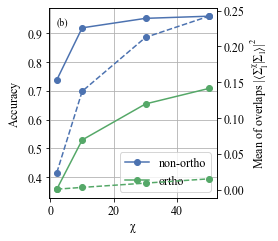

In [45]:
Plotting(mapping_basis=['original', 'orthogonal'])

In [47]:
with open(f'results/original/parallel_chi2.p', 'rb') as f:
    a = pickle.load(f)

{0: [array([[[1., 0.],
          [0., 0.]]]),
  array([[[1., 0.],
          [0., 0.]],
  
         [[0., 1.],
          [0., 0.]]]),
  array([[[1., 0.],
          [0., 0.]],
  
         [[0., 1.],
          [0., 0.]]]),
  array([[[1., 0.],
          [0., 0.]],
  
         [[0., 1.],
          [0., 0.]]]),
  array([[[1., 0.],
          [0., 0.]],
  
         [[0., 1.],
          [0., 0.]]]),
  array([[[1.00000000e+00, 0.00000000e+00],
          [1.03284875e-70, 6.29883443e-71]],
  
         [[0.00000000e+00, 1.00000000e+00],
          [0.00000000e+00, 0.00000000e+00]]]),
  array([[[ 1.00000000e+00,  0.00000000e+00],
          [ 3.34645095e-64,  9.94339020e-71]],
  
         [[-3.34645095e-64,  4.87221625e-07],
          [ 1.00000000e+00,  2.97132405e-07]]]),
  array([[[ 1.00000000e+000,  0.00000000e+000],
          [ 1.59008762e-057,  9.89907951e-058]],
  
         [[ 1.18071820e-107,  1.00000000e+000],
          [-5.35144465e-051, -3.33153817e-051]]]),
  array([[[ 1.00000000e+00,  0.00

In [51]:
a.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])